## Hyperparameter Tuning für Lastprognose mit Optuna und PyTorch

Supervised ML algorithms: `PyTorch` ANN

Hyperparameter tuning framework: `Optuna`

Training Data:
- \\main\apl\TradingApps\OperationsResearch\ProjectsAndAnalysis\AnalysisScripts\Python

Target Variable:
- Viertelstündliche Grösse, die Aggregation

Training/Testing/Validation:
- Training 01/19-03/22
- Test 04/22-03/23
- Validation 04/23-06/23

Notes:  

Historie_für_Training → falls leer fliessen die Tage nicht ins Training ein  
Tagestyp Bern → Klassen, der Rest ist linear oder stückweise linear abgebildet  

In [2]:
import optuna
from optuna.integration.tensorboard import TensorBoardCallback
from optuna.trial import TrialState

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import comma_format, percent_format, currency_format
from datetime import datetime, timedelta, date
from tqdm.notebook import tqdm
from skimpy import clean_columns
from IPython.display import clear_output, display
import holidays
from pickle import dump, load
import warnings

pd.set_option("display.max.columns", 50)

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


### Reading in the Preprocessed Data and Making Base Splits

In [3]:
df = pd.read_csv("Preprocessed Data/df_base_trainval_preprocessed.csv", parse_dates=["Zeitstempel"])

In [4]:
X, y = df.drop(["Zeitstempel", "MWh"], axis=1), df["MWh"]

In [5]:
preprocessor = load(open('Models/sklearn_base_pipeline_unfitted.pickle', 'rb'))

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

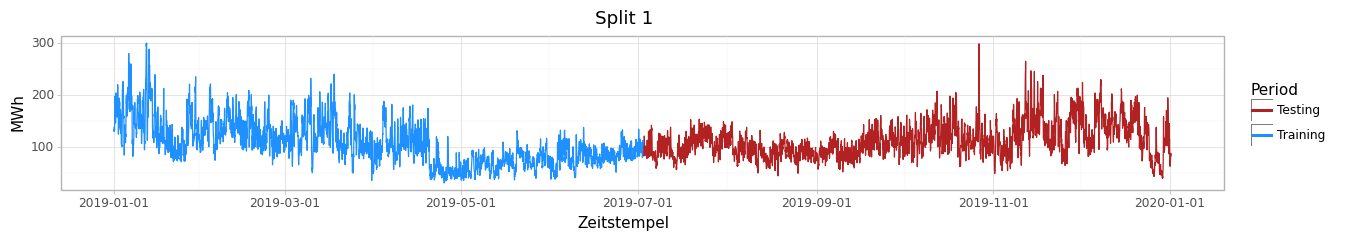

<ggplot: (164836628586)>

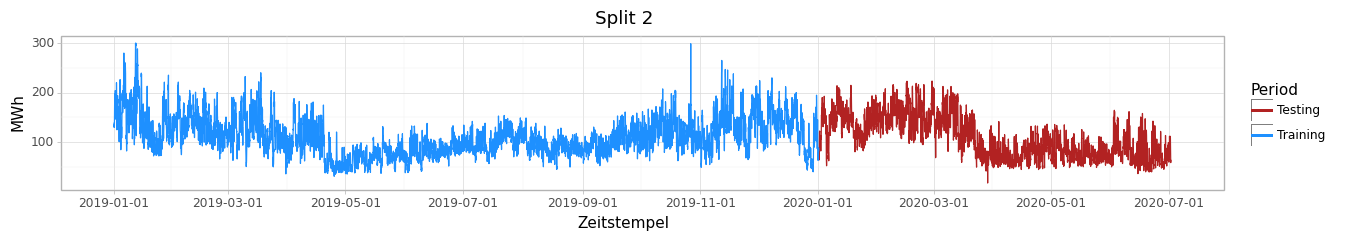

<ggplot: (164836665750)>

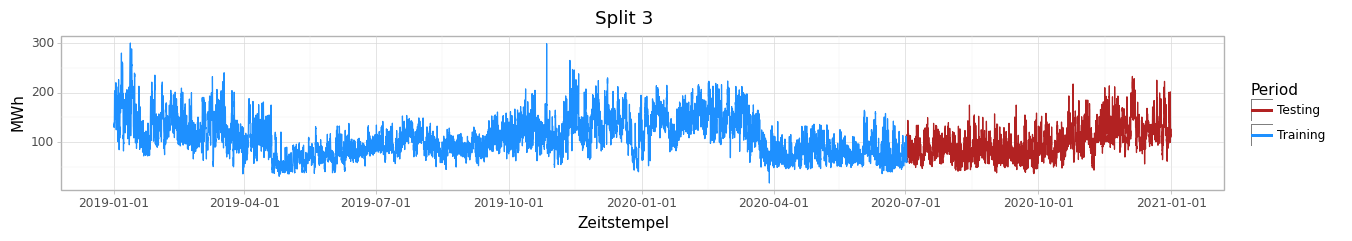

<ggplot: (164836742901)>

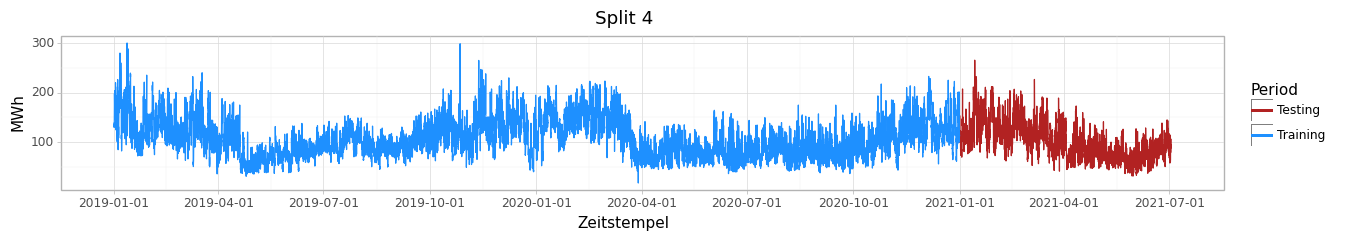

<ggplot: (164836733739)>

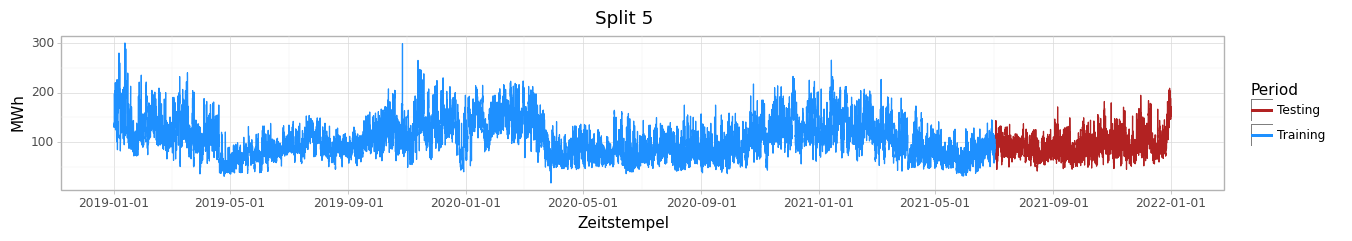

<ggplot: (164839420703)>

In [7]:
# Iterate through the splits
for split_idx, (train_index, test_index) in enumerate(tscv.split(X)):
    train_dates = df["Zeitstempel"].iloc[train_index]
    test_dates = df["Zeitstempel"].iloc[test_index]

    y_train, y_test = pd.DataFrame(
        {
            "Zeitstempel": train_dates.reset_index(drop=True),
            "MWh": y.iloc[train_index].reset_index(drop=True),
            "Period": "Training",
        }
    ), pd.DataFrame(
        {
            "Zeitstempel": test_dates.reset_index(drop=True),
            "MWh": y.iloc[test_index].reset_index(drop=True),
            "Period": "Testing",
        }
    )

    with warnings.catch_warnings():  # sanest pandas user
        warnings.simplefilter("ignore")

        p = (
            ggplot(
                data=pd.concat([y_train, y_test], axis=0),
                mapping=aes(x="Zeitstempel", y="MWh", colour="Period"),
            )
            + labs(title=f"Split {split_idx + 1}")
            + geom_line()
            + scale_colour_manual(values=["firebrick", "dodgerblue"])
            + theme_light()
            + theme(figure_size=[15, 2])
        )
        display(p)

In [8]:
class CustomDataset(torch.utils.data.Dataset):
  '''
  Prepare the custom dataset for regression
  '''

  def __init__(self, X, y):
    # Normally, here would be the sklearn part, which I've done above

    if not torch.is_tensor(X) and not torch.is_tensor(y):
      self.X = torch.from_numpy(np.float32(np.asarray(X)))
      self.y = torch.from_numpy(np.float32(np.asarray(y)))

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

### Training and Tuning with PyTorch and Optuna

Training on Training  
Validating on Validation  

In [10]:
class LSTMModel(nn.Module):
    def init(self, input_size, hidden_size, num_layers, output_size, noise_stddev=0.01):
        super(LSTMModel, self).init()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM layer with noise
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.add_noise_to_weights(self.lstm, noise_stddev)

        # Define the output layer with noise
        self.fc = nn.Linear(hidden_size, output_size)
        self.add_noise_to_weights(self.fc, noise_stddev)

    def add_noise_to_weights(self, layer, noise_stddev):
        for param in layer.parameters():
            if param.requires_grad:
                param.data += torch.randn_like(param) * noise_stddev

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hiddensize).to(x.device)
        out,  = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    train_loss = 0
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= num_batches

    return train_loss
    

def val_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    val_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()
            val_loss += loss_fn(pred, y).item()

    val_loss /= num_batches

    return val_loss

Objective function:

In [12]:
def objective(trial):
    """Objective function to be optimized by Optuna"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    batch_size = trial.suggest_categorical(
        "batch_size", [int(2 ** x) for x in np.arange(4, 10)]
    )

    # Make data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Suggest hyperparameters
    n_epochs = trial.suggest_int("n_epochs", 5, 50)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("learning_rate", 0.00001, 0.1)

    # Generate the model
    model = ANN(trial=trial, num_layers=num_layers).to(device)

    # Generate the optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create separate SummaryWriter for each trial
    log_dir = f"./tensorboard_logs/ann_newsplits_nopv_trial_{trial.number}"
    my_summary_writer = SummaryWriter(log_dir=log_dir)

    # Training of the model
    for epoch in range(n_epochs):
        train_loss = train_loop(train_loader, model, loss_fn, optimizer)  # Train the model
        val_loss = val_loop(val_loader, model, loss_fn)  # Evaluate the model

        # Log training and validation loss
        my_summary_writer.add_scalars(
            f"loss{trial.number}",
            {
                "train": train_loss,
                "val": val_loss,
            },
            epoch,
        )

        # Update best_val_loss and save a general checkpoint if necessary
        global best_val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint = {
                'epoch': epoch,
                "batch_size": batch_size,
                "n_epochs": n_epochs,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }
            torch.save(checkpoint, f"Model Checkpoints/ann_newsplits_nopv.pt")

        # For pruning (stops trial early if not promising)
        trial.report(val_loss, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

Run the trial:

In [13]:
# --- Parameters ----------------------------------------------------------
number_of_trials = 500 # Number of Optuna trials

# Make runs repeatable
random_seed = 1
torch.manual_seed(random_seed)

# Initialize the best validation loss across trials
best_val_loss = float('inf')

# Create an Optuna study to maximize test accuracy
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10, n_min_trials=5))
study.optimize(objective, n_trials=number_of_trials, timeout=3600*20)

[I 2023-08-19 22:02:13,858] A new study created in memory with name: no-name-f2d71c94-e51d-46a5-95da-4f3c97bdba6a


[I 2023-08-19 22:05:15,061] Trial 0 finished with value: 4039796366.0145984 and parameters: {'batch_size': 256, 'n_epochs': 31, 'num_layers': 2, 'learning_rate': 0.030207827065102964, 'n_units_l1': 16}. Best is trial 0 with value: 4039796366.0145984.
[I 2023-08-19 22:05:48,636] Trial 1 finished with value: 3197388043.130435 and parameters: {'batch_size': 512, 'n_epochs': 9, 'num_layers': 3, 'learning_rate': 0.08280331802092222, 'n_units_l1': 16, 'n_units_l2': 32}. Best is trial 1 with value: 3197388043.130435.
[I 2023-08-19 22:09:48,502] Trial 2 finished with value: 2275544271.649635 and parameters: {'batch_size': 128, 'n_epochs': 25, 'num_layers': 3, 'learning_rate': 0.017324818761501944, 'n_units_l1': 32, 'n_units_l2': 32}. Best is trial 2 with value: 2275544271.649635.
[I 2023-08-19 22:11:16,586] Trial 3 finished with value: 1941945416.347826 and parameters: {'batch_size': 512, 'n_epochs': 26, 'num_layers': 3, 'learning_rate': 0.07922096080692144, 'n_units_l1': 16, 'n_units_l2': 16}

In [14]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Display the study statistics
print("\nStudy statistics: ")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")


Study statistics: 
  Number of finished trials: 281
  Number of pruned trials: 80
  Number of complete trials: 201


In [15]:
study.best_value

1462053091.076221

In [16]:
study.best_params

{'batch_size': 16,
 'n_epochs': 17,
 'num_layers': 3,
 'learning_rate': 0.08604486474542629,
 'n_units_l1': 8,
 'n_units_l2': 64}

Save the best hyperparameter combination to models folder (commented out in order not to overwrite by accident):

In [17]:
with open("Models/ANN_hyperparams.pickle", 'wb') as file:
    dump(study.best_params, file)

Hyperparameter Importance:

In [18]:
# Display the most important hyperparameters
print('\nMost important hyperparameters:')
for key, value in optuna.importance.get_param_importances(study, target=None).items():
    print('  {}:{}{:.2f}%'.format(key, (15-len(key))*' ', value*100))


Most important hyperparameters:
  num_layers:     42.29%
  n_units_l1:     24.83%
  batch_size:     13.04%
  n_epochs:       10.13%
  learning_rate:  9.71%


### Reading in the Best Configuration from Checkpoint

Nice to have, but this is not used for the model that is used to make predictions on the validation period.

In [19]:
class ANN(nn.Module):
    """Artificial Neural Network for final fit for load forecast."""
    def __init__(self, num_layers, n_units_list):
        
        super(ANN, self).__init__()
        
        # Define the convolutional layers
        self.layer_list = []
        in_size = X_train.shape[1]
        
        for i in range(1, num_layers):
            out_size = n_units_list[i-1]
            self.layer_list.append(nn.Linear(in_size, out_size))
            self.layer_list.append(nn.ReLU())
            in_size = out_size

        # Define output layer
        self.layer_list.append(nn.Linear(in_size, 1))

        self.layers = nn.Sequential(*self.layer_list)

    def forward(self, x):
        """Forward propagation"""
        return self.layers(x)

In [20]:
checkpoint = torch.load("./Model Checkpoints/ann_newsplits_nopv.pt")

# Get size of each layer from state dictionary
n_units_list = []
for name, tensor in checkpoint["model_state_dict"].items():
    if "bias" in name:
        n_units_list.append(tensor.shape[0])
n_units_list = n_units_list[:-1]

model = ANN(num_layers=checkpoint["num_layers"], n_units_list=n_units_list)
optimizer = torch.optim.Adam(model.parameters(), lr=checkpoint["learning_rate"])

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [21]:
def format_float_with_4_decimals(x):
    return "{:.4f}".format(x)


(
    pd.DataFrame(
        {
            "actuals": y_val,
            "y_pred_test": model(torch.Tensor(X_val.values)).squeeze().tolist(),
        }
    )
    .melt(id_vars="actuals", var_name="model", value_name="pred")
    .groupby("model")
    .apply(
        lambda x: pd.Series(
            {
                "R2": r2_score(x["actuals"], x["pred"]),
                "MAPE": mean_absolute_percentage_error(x["actuals"], x["pred"]),
                "MSE": mean_squared_error(x["actuals"], x["pred"]),
                "RMSE": mean_squared_error(x["actuals"], x["pred"], squared=False),
            }
        )
    )
    .reset_index()
    .melt(id_vars="model", var_name="metric_name")
    .pivot(columns="model", index="metric_name", values="value")
    .reset_index()
    .rename_axis(None, axis=1)
    .style.format(
        {
            "y_pred_val": format_float_with_4_decimals,
        }
    )
)

,metric_name,y_pred_test
0,MAPE,0.062447
1,MSE,1390918757.879048
2,R2,0.931872
3,RMSE,37295.023232


### Training Best Model on Training Data

Now that the best hyperparameters are known, let's train the best model on the training data, in order to make predictions on the validation dataset, which are then used to tune the meta model.

In [22]:
# Read in best hyperparameter combination from tuning
with open("Models/ANN_hyperparams.pickle", 'rb') as file:
    best_config = load(file)

n_units_list = [value for key, value in best_config.items() if "n_units" in key]

In [23]:
best_config

{'batch_size': 16,
 'n_epochs': 17,
 'num_layers': 3,
 'learning_rate': 0.08604486474542629,
 'n_units_l1': 8,
 'n_units_l2': 64}

In [24]:
# Base Model Splits
train_loader = DataLoader(train_dataset, batch_size=best_config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_config["batch_size"], shuffle=False)

In [25]:
def evaluation_plot(train_losses, test_losses):
    p = (
        ggplot(
            data=pd.DataFrame(
                {
                    "train": train_losses,
                    "test": test_losses,
                    "epoch": np.arange(1 + 5, len(train_losses) + 1 + 5),
                }
            ).melt(id_vars="epoch"),
            mapping=aes(x="epoch", y="value", colour="variable"),
        )
        + geom_line()
        + labs(
            title="Training vs. Testing Loss by Epoch for Final Model Configuration",
            y="MSE",
            colour="",
            x="Epochs",
        )
        + scale_colour_manual(values=["firebrick", "midnightblue"])
        + theme_bw()
        + theme(figure_size=[8, 4],
        panel_grid_minor_y = element_blank())
    )
    return p

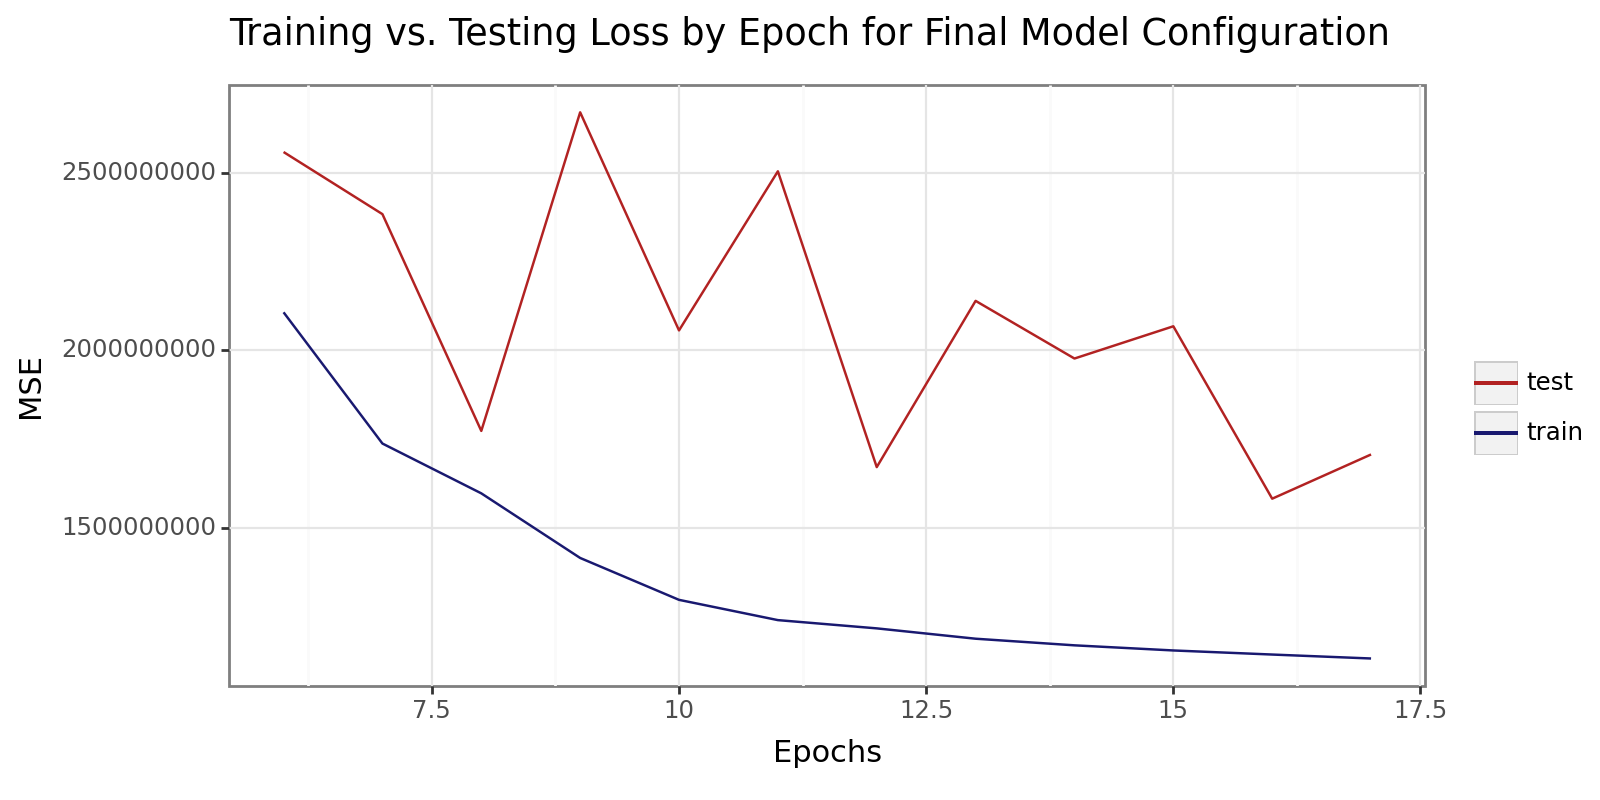

<Figure Size: (800 x 400)>

In [26]:
# Define the model
torch.manual_seed(1)
model = ANN(num_layers=best_config["num_layers"], n_units_list=n_units_list)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_config["learning_rate"])

# Store losses for later plot
train_losses = []
test_losses = []

# Get additional two hyperparameters
total_epochs = best_config["n_epochs"]

# Train model with same amount of epochs
for t in range(total_epochs):

    clear_output(wait=True)

    # Training
    train_loss = train_loop(
        dataloader=train_loader,
        loss_fn=loss_function,
        model=model,
        optimizer=optimizer,
    )
    train_losses.append(train_loss)

    # Testing
    test_loss = val_loop(dataloader=val_loader, model=model, loss_fn=loss_function)
    test_losses.append(test_loss)

    # Plotting
    if t > 10:
        p = evaluation_plot(train_losses[5:], test_losses[5:])
        display(p)

In [27]:
pytorch_train_model = {
    "num_layers": best_config["num_layers"],
    "n_units_list": n_units_list,
    "model_state_dict": model.state_dict(),
}
torch.save(pytorch_train_model, f"Models/ann_newsplits_nopv_train.pt")

In [28]:
def format_float_with_4_decimals(x):
    return "{:.4f}".format(x)


(
    pd.DataFrame(
        {
            "actuals": y_val,
            "y_pred_test": model(torch.Tensor(X_val.values)).squeeze().tolist(),
        }
    )
    .melt(id_vars="actuals", var_name="model", value_name="pred")
    .groupby("model")
    .apply(
        lambda x: pd.Series(
            {
                "R2": r2_score(x["actuals"], x["pred"]),
                "MAPE": mean_absolute_percentage_error(x["actuals"], x["pred"]),
                "MSE": mean_squared_error(x["actuals"], x["pred"]),
                "RMSE": mean_squared_error(x["actuals"], x["pred"], squared=False),
            }
        )
    )
    .reset_index()
    .melt(id_vars="model", var_name="metric_name")
    .pivot(columns="model", index="metric_name", values="value")
    .reset_index()
    .rename_axis(None, axis=1)
    .style.format(
        {
            "y_pred_val": format_float_with_4_decimals,
        }
    )
)

,metric_name,y_pred_test
0,MAPE,0.068331
1,MSE,1707795560.505273
2,R2,0.916351
3,RMSE,41325.483185


In [29]:
y_pred_val = model(torch.Tensor(X_val.values)).squeeze().tolist()

In [30]:
predictions = pd.DataFrame(
    {
        "datetime": (
            df.query("datetime >= @pd.Timestamp('2022-04-01 00:00')")
            .query("datetime < @pd.Timestamp('2023-04-01 00:00')")["datetime"]
            .to_list()
        ),
        "pytorch_newsplits_nopv": y_pred_val,
    }
)

predictions.to_csv("Predictions/val_pytorch_newsplits_nopv.csv", index=False)

### Training Best Model on Training + Validation Data

The best hyperparameters for this model are already known, so let's train the best model on the training AND validation data, in order to make predictions on the test dataset, which are then used to make predictions with by the meta model.

In [31]:
# Read in best hyperparameter combination from tuning
with open("Models/ANN_hyperparams.pickle", 'rb') as file:
    best_config = load(file)

n_units_list = [value for key, value in best_config.items() if "n_units" in key]

In [32]:
preprocessor = load(open('Models/sklearn_base_pipeline_unfitted.pickle', 'rb'))

In [33]:
df = pd.read_pickle("Preprocessed Data/df_base_preprocessed.pickle")

X_train_final = (
    df.query("datetime < @pd.Timestamp('2023-04-01 00:00')")
    .drop(["datetime", "kW"], axis=1)
    .reset_index(drop=True)
)
y_train_final = df.query("datetime < @pd.Timestamp('2023-04-01 00:00')")["kW"].reset_index(
    drop=True
)

In [34]:
df_test = pd.read_pickle("Preprocessed Data/df_base_preprocessed_holdout.pickle")

X_test = df_test.drop(["datetime", "kW"], axis=1).reset_index(drop=True)

y_test = df_test["kW"].reset_index(drop=True)

In [35]:
fitted_preprocessor = preprocessor.fit(X_train_final)

In [36]:
X_train_final = pd.DataFrame(
    fitted_preprocessor.transform(X_train_final),
    columns=fitted_preprocessor.get_feature_names_out(),
)

X_test = pd.DataFrame(
    fitted_preprocessor.transform(X_test),
    columns=fitted_preprocessor.get_feature_names_out(),
)

In [37]:
train_final_dataset = CustomDataset(X=X_train_final, y=y_train_final)
test_dataset = CustomDataset(X=X_test, y=y_test)

train_final_dataloader = DataLoader(
    train_final_dataset, batch_size=best_config["batch_size"], shuffle=True
)
test_loader = DataLoader(test_dataset, batch_size=best_config["batch_size"], shuffle=False)

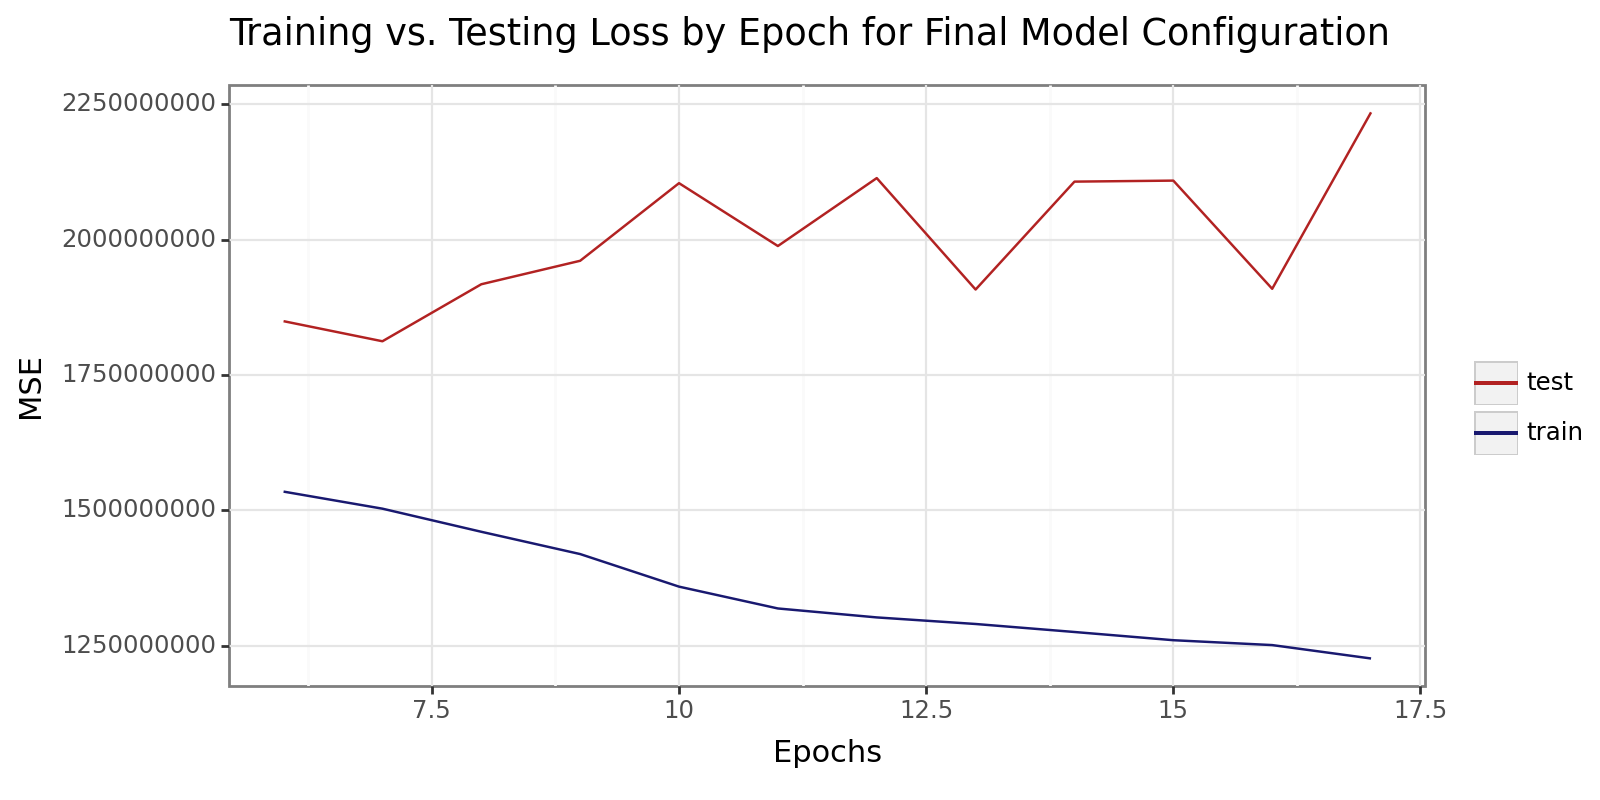

<Figure Size: (800 x 400)>

In [38]:
# Define the model
torch.manual_seed(1)
model = ANN(num_layers=best_config["num_layers"], n_units_list=n_units_list)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_config["learning_rate"])

# Store losses for later plot
train_losses = []
test_losses = []

# Get additional two hyperparameters
total_epochs = best_config["n_epochs"]
n_units_list = [value for key, value in best_config.items() if "n_units" in key]

# Train model with same amount of epochs
for t in range(total_epochs):

    clear_output(wait=True)

    # Training
    train_loss = train_loop(
        dataloader=train_final_dataloader,
        loss_fn=loss_function,
        model=model,
        optimizer=optimizer,
    )
    train_losses.append(train_loss)

    # Testing
    test_loss = val_loop(dataloader=test_loader, model=model, loss_fn=loss_function)
    test_losses.append(test_loss)

    # Plotting
    if t > 10:
        p = evaluation_plot(train_losses[5:], test_losses[5:])
        display(p)

In [39]:
final_model = {
    "num_layers": best_config["num_layers"],
    "n_units_list": n_units_list,
    "model_state_dict": model.state_dict(),
}
torch.save(final_model, f"Models/ann_newsplits_nopv_trainval.pt.pt")

In [40]:
def format_float_with_4_decimals(x):
    return "{:.4f}".format(x)


(
    pd.DataFrame(
        {
            "actuals": y_test,
            "y_pred_test": model(torch.Tensor(X_test.values)).squeeze().tolist(),
        }
    )
    .melt(id_vars="actuals", var_name="model", value_name="pred")
    .groupby("model")
    .apply(
        lambda x: pd.Series(
            {
                "R2": r2_score(x["actuals"], x["pred"]),
                "MAPE": mean_absolute_percentage_error(x["actuals"], x["pred"]),
                "MSE": mean_squared_error(x["actuals"], x["pred"]),
                "RMSE": mean_squared_error(x["actuals"], x["pred"], squared=False),
            }
        )
    )
    .reset_index()
    .melt(id_vars="model", var_name="metric_name")
    .pivot(columns="model", index="metric_name", values="value")
    .reset_index()
    .rename_axis(None, axis=1)
    .style.format(
        {
            "y_pred_val": format_float_with_4_decimals,
        }
    )
)

,metric_name,y_pred_test
0,MAPE,0.110915
1,MSE,2234908933.951405
2,R2,0.837263
3,RMSE,47274.823468


In [41]:
y_pred_test = model(torch.Tensor(X_test.values)).squeeze().tolist()

In [42]:
predictions = pd.DataFrame(
    {
        "datetime": df_test["datetime"],
        "pytorch_newsplits_nopv": y_pred_test,
    }
)

predictions.to_csv("Predictions/test_pytorch_newsplits_nopv.csv", index=False)